1. Theory Questions:

• Q1: Explain the minimax loss function in GANs and how it ensures competitive training between the generator and discriminator.

Ans:The minimax loss function in GANs formulates training as a two-player game between the Generator (G) and the Discriminator (D). The discriminator aims to correctly classify real and fake images, while the generator tries to produce images that can fool the discriminator.

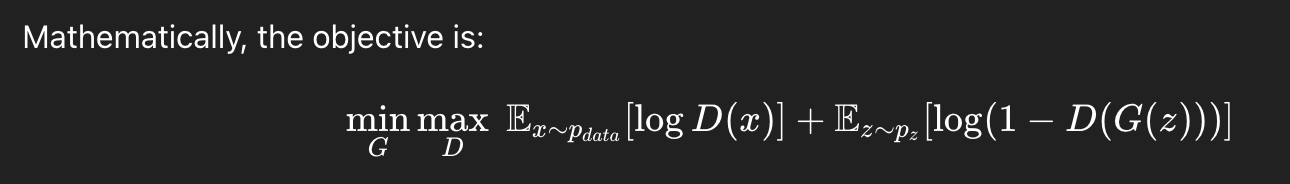

This competitive setup ensures that both models improve iteratively, leading the generator to learn the real data distribution.


• Q2: What is mode collapse, Why can mode collapse occur during GAN training? and how can it be mitigated?

Ans: Mode collapse in GANs occurs when the generator produces a limited set of repetitive outputs instead of capturing the full data distribution. This happens when the generator exploits weaknesses in the discriminator, learning to produce only a few patterns that consistently fool it. The issue arises due to imbalanced training, instability in optimization, or lack of diversity in updates. To mitigate mode collapse, techniques such as minibatch discrimination, feature matching, Wasserstein GANs (WGAN), unrolled GANs, and label smoothing can be used. These methods encourage the generator to produce more diverse outputs, stabilize training, and prevent it from converging to a narrow subset of the data distribution.

• Q3: Explain the role of the discriminator in adversarial training?

Ans:The discriminator functions as a binary classification system which identifies which images are authentic and which images are computer-generated. The system generates valuable gradients which assist the generator operation throughout its training process. A properly functioning discriminator system maintains stable adversarial training while enhancing the performance of the generator system.

• Q4: How do metrics like IS and FID evaluate GAN performance

Ans: Inception Score (IS) and Fréchet Inception Distance (FID) are commonly used metrics to evaluate GAN performance. IS measures the quality and diversity of generated images using a pre-trained Inception network, where higher scores indicate better diversity and realism. However, IS does not compare generated images to real data. In contrast, FID calculates the distance between real and generated image distributions using feature representations from an Inception model. A lower FID score suggests that generated images are more similar to real ones, making it a more reliable evaluation metric. FID is generally preferred as it captures both quality and diversity while considering real data distribution.



In [3]:
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os


Load and Preprocess CIFAR-10 Dataset

In [4]:
(train_images, _), (_, _) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize to [-1, 1]

BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Generator Model (with Extra Convolutional Layers)

In [5]:
def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(4*4*512, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Reshape((4, 4, 512)),

        # 4x4 → 8x8
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 8x8 → 16x16
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # 16x16 → 32x32
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        # Final output: 32x32x3
        layers.Conv2DTranspose(3, 3, strides=1, padding='same',
                               use_bias=False, activation='tanh')
    ])
    return model


Discriminator Model

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 4, strides=2, padding='same', input_shape=[32,32,3]),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(128, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Conv2D(256, 4, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1)
    ])
    return model


Define Loss Functions

In [7]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


Initialize Models and Optimizers

In [8]:
generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Step

In [9]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    generator_optimizer.apply_gradients(
        zip(gen_tape.gradient(gen_loss, generator.trainable_variables),
            generator.trainable_variables))

    discriminator_optimizer.apply_gradients(
        zip(disc_tape.gradient(disc_loss, discriminator.trainable_variables),
            discriminator.trainable_variables))

    return gen_loss, disc_loss


Saving Generated Images Every 10 Epochs

In [10]:
def save_images(model, epoch):
    noise = tf.random.normal([16, 100])
    predictions = model(noise, training=False)
    predictions = (predictions + 1) / 2

    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs("generated_images", exist_ok=True)
    plt.savefig(f"generated_images/epoch_{epoch}.png")
    plt.show()


Training Loop

Epoch 1, Generator Loss: 0.8075, Discriminator Loss: 1.4528
Epoch 2, Generator Loss: 0.7955, Discriminator Loss: 1.3134
Epoch 3, Generator Loss: 0.7975, Discriminator Loss: 1.2977
Epoch 4, Generator Loss: 0.7050, Discriminator Loss: 1.4125
Epoch 5, Generator Loss: 0.6862, Discriminator Loss: 1.4165
Epoch 6, Generator Loss: 0.6121, Discriminator Loss: 1.3610
Epoch 7, Generator Loss: 0.7064, Discriminator Loss: 1.3152
Epoch 8, Generator Loss: 0.6364, Discriminator Loss: 1.4221
Epoch 9, Generator Loss: 0.7865, Discriminator Loss: 1.1790
Epoch 10, Generator Loss: 0.7117, Discriminator Loss: 1.4438


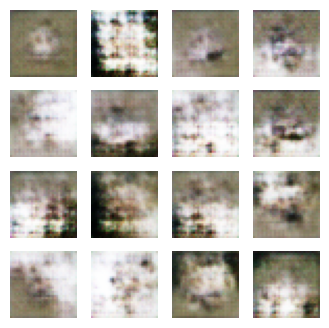

Epoch 11, Generator Loss: 0.7355, Discriminator Loss: 1.2617
Epoch 12, Generator Loss: 0.7617, Discriminator Loss: 1.3766
Epoch 13, Generator Loss: 0.9475, Discriminator Loss: 1.1575
Epoch 14, Generator Loss: 0.7383, Discriminator Loss: 1.3531
Epoch 15, Generator Loss: 0.7540, Discriminator Loss: 1.3807
Epoch 16, Generator Loss: 0.8163, Discriminator Loss: 1.1495
Epoch 17, Generator Loss: 0.7752, Discriminator Loss: 1.3205
Epoch 18, Generator Loss: 0.8507, Discriminator Loss: 1.1898
Epoch 19, Generator Loss: 0.9096, Discriminator Loss: 0.9610
Epoch 20, Generator Loss: 0.8154, Discriminator Loss: 1.4761


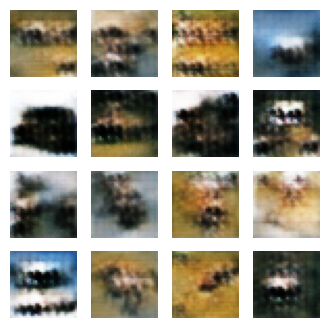

Epoch 21, Generator Loss: 0.9183, Discriminator Loss: 1.1686
Epoch 22, Generator Loss: 0.8758, Discriminator Loss: 1.2073
Epoch 23, Generator Loss: 1.0337, Discriminator Loss: 1.0703
Epoch 24, Generator Loss: 0.9561, Discriminator Loss: 1.0761
Epoch 25, Generator Loss: 1.0438, Discriminator Loss: 0.9877
Epoch 26, Generator Loss: 0.8633, Discriminator Loss: 1.1129
Epoch 27, Generator Loss: 0.9865, Discriminator Loss: 1.2024
Epoch 28, Generator Loss: 1.0466, Discriminator Loss: 1.0094
Epoch 29, Generator Loss: 1.0054, Discriminator Loss: 1.2734
Epoch 30, Generator Loss: 1.0174, Discriminator Loss: 1.2214


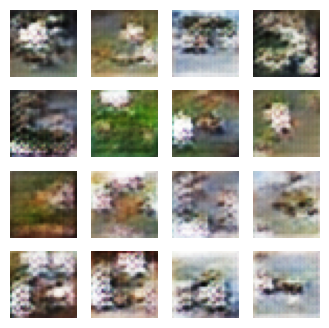

Epoch 31, Generator Loss: 1.0339, Discriminator Loss: 1.1514
Epoch 32, Generator Loss: 0.8625, Discriminator Loss: 1.2893
Epoch 33, Generator Loss: 0.9919, Discriminator Loss: 1.0680
Epoch 34, Generator Loss: 0.9876, Discriminator Loss: 1.0985
Epoch 35, Generator Loss: 0.8395, Discriminator Loss: 1.2402
Epoch 36, Generator Loss: 1.1362, Discriminator Loss: 1.0766
Epoch 37, Generator Loss: 1.2718, Discriminator Loss: 1.0363
Epoch 38, Generator Loss: 0.8320, Discriminator Loss: 1.3610
Epoch 39, Generator Loss: 0.8327, Discriminator Loss: 1.2481
Epoch 40, Generator Loss: 0.9506, Discriminator Loss: 1.2990


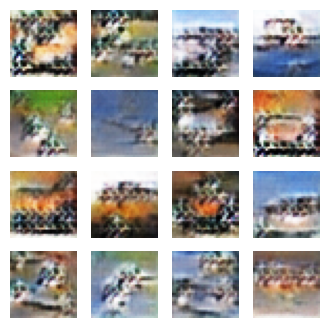

Epoch 41, Generator Loss: 0.9392, Discriminator Loss: 1.1826
Epoch 42, Generator Loss: 1.0063, Discriminator Loss: 1.0773
Epoch 43, Generator Loss: 0.8702, Discriminator Loss: 1.2425
Epoch 44, Generator Loss: 0.9287, Discriminator Loss: 0.9938
Epoch 45, Generator Loss: 0.8968, Discriminator Loss: 1.2623
Epoch 46, Generator Loss: 0.8718, Discriminator Loss: 1.1862
Epoch 47, Generator Loss: 0.8465, Discriminator Loss: 1.3638
Epoch 48, Generator Loss: 0.9159, Discriminator Loss: 1.2086
Epoch 49, Generator Loss: 1.1545, Discriminator Loss: 0.9974
Epoch 50, Generator Loss: 0.7891, Discriminator Loss: 1.3036


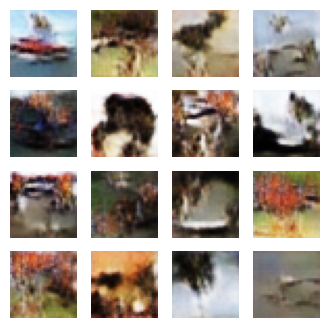

In [11]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f"Epoch {epoch+1}, "
              f"Generator Loss: {gen_loss:.4f}, "
              f"Discriminator Loss: {disc_loss:.4f}")

        if (epoch + 1) % 10 == 0:
            save_images(generator, epoch + 1)

train(train_dataset, epochs=50)
